# 📊 Análise Exploratória de Dados reais de filmes do IMDB

Esse arquivo do Jupyter Notebook contempla o meu projeto realizado para apresentar uma análise exploratória de dados usando Linguagem Python, Linguagem SQL e Banco de Dados SQLite. Para tal usei dados reais disponíveis publicamente, dados sobre filmes no site [IMDB](https://www.imdb.com/?ref_=nv_home), que é um site de avaliação e classificação de filmes, séries e programas de TV.

Aqui nesse notebook, irei explicar o passo a passo utilizado para responder às perguntas indicadas no [arquivo README](https://github.com/AndersonGabrielCalasans/iniciacao-ciencia-de-dados-DSA#readme) do diretório principal, que foram:

- 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?
- 2- Qual o Número de Títulos Por Gênero?
- 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?
- 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
- 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
- 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
- 7- Qual a Relação Entre Duração e Gênero?
- 8- Qual o Número de Filmes Produzidos Por País?
- 9- Quais São os Top 10 Melhores Filmes?
- 10- Quais São os Top 10 Piores Filmes?

## Instalando e Carregando Pacotes - preparando o ambiente

A **versão do Jupyter Python** que foi testada e aplicada o projeto a seguir foi **3.9.12**.

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


### Bibliotecas e pacotes utilizados

Para realizar a leitura e acesso ao banco de dados do IMDB, que foram baixados [nesse link](https://www.imdb.com/interfaces/) no dia 08/09/2022, irei utilizar a biblioteca Python **imdb-sqlite**, na versão 0.1.3, que está disponível no site da [PyPI](https://pypi.org/). Essa biblioteca importa arquivos IMDB TSV para um banco de dados SQLite e será fundamental para facilitar o tratamento e extruturação desses dados. A biblioteca citada, está disponível no link: [imdb-sqlite](https://pypi.org/project/imdb-sqlite/). 

In [2]:
# Instala o pacote imdb-sqlite no Jupyter Notebook:
!pip install -q imdb-sqlite

Além do imdb-sqlite, realizaremos a instalação de outra biblioteca que ainda não tinha utilizado, a **pycountry**, na versão 22.3.5, também disponivel no PyPI [neste link](https://pypi.org/project/pycountry/), que fornece os bancos de dados ISO para os padrões de nomes de: países, idiomas e moedas, principalmente e será interessante para nós acessarmos o nome dos países de forma mais rápida, sem precisar realizar nenhuma conversão manual. 

In [3]:
# Instala o pacote pycountry no Jupyter Notebook:
!pip install -q pycountry

Os demais pacotes e bibliotecas utilizados nesse projeto, já foram antes utilizados por mim ou já vieram instalados com o pacote do anaconda Python, um resumo sobre a utilização de cada uma delas está disponível no README principal desse diretório.

In [4]:
# Imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

### Carregando os Dados

O primeiro passo após importar as bibliotecas que usaremos é baixar e carregar os dados para que possamos fazer a análise dos mesmos.

In [5]:
%%time
!imdb-sqlite

CPU times: total: 15.6 ms
Wall time: 344 ms


2022-09-22 12:52:51,184 DB already exists: (imdb.db). Refusing to modify. Exiting


In [6]:
# Conectando no banco de dados
conn = sqlite3.connect("imdb.db")

In [7]:
# Extrai uma lista com as tabelas presentes no imdb.db
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [8]:
#Verifica o tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [9]:
# Visualizando a lista com os nomes das tabelas do DB
print(tabelas)

  Table_Name
0     people
1     titles
2       akas
3       crew
4   episodes
5    ratings


In [10]:
# Convertendo o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [11]:
# Gerando um loop que percorre a lista de tabelas do banco de dados e extrai o schema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Com base nas informações obtidas podemos observar o schema de tada tabela e o tipo de dado que cada instância vai receber, além de informações como: se a variável pode ser instanciada com valor nulo e se ela é uma chave primária ou não, o que vai nos fornecer o necessário para realizarmos nossa análise.

### Respondendo as perguntas e realizando a Análise Exploratória de Dados

#### 1- Quais são as categorias de filmes mais comuns no IMDB?
Desejamos saber quais são os principais tipos (categorias) dos títulos (filmes), vamos seguir o passo a diante 

In [12]:
# Cria a consulta SQL
query_type_titles = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [13]:
# Extrai o resultado
result_type_titles = pd.read_sql_query(query_type_titles, conn)

In [14]:
# Visualiza o resultado
display(result_type_titles)

,type,COUNT
0,movie,619593
1,short,886148
2,tvEpisode,6920413
3,tvMiniSeries,44866
4,tvMovie,137301
5,tvPilot,2
6,tvSeries,230122
7,tvShort,10637
8,tvSpecial,38065
9,video,264553


In [15]:
# Calculo percentual para cada type
result_type_titles['percentual'] = (result_type_titles['COUNT'] / result_type_titles['COUNT'].sum())*100
display(result_type_titles)

,type,COUNT,percentual
0,movie,619593,6.746697
1,short,886148,9.649193
2,tvEpisode,6920413,75.355809
3,tvMiniSeries,44866,0.488542
4,tvMovie,137301,1.495059
5,tvPilot,2,0.000022
6,tvSeries,230122,2.505780
7,tvShort,10637,0.115825
8,tvSpecial,38065,0.414487
9,video,264553,2.880696


A partir dessa primeira análise gerada já podemos imaginar o por quê do type ***tvEpisode*** ser o predominante, pois o mesmo título têm vários episódios.
Para facilitar a visualização irei criar um **gráfico** com apenas **4 categorias**, sendo as 3 primeiras contendo os tipos com os maiores valores percentuais e a 4º com as demais, para isso:

In [16]:
# Agrupando os demais types em 'othes':

others = {}
others['COUNT'] = result_type_titles[result_type_titles['percentual'] < 5]['COUNT'].sum()
others['percentual'] = result_type_titles[result_type_titles['percentual'] < 5]['percentual'].sum()
others['type'] = 'others'
print(others)

{'COUNT': 757495, 'percentual': 8.248300866028307, 'type': 'others'}


In [17]:
# Filtrando o dataframe de resultadotype_titles
result_type_titles = result_type_titles[result_type_titles['percentual'] > 5]

In [18]:
# Realizando append com o dataframe others
result_type_titles = result_type_titles.append(others, ignore_index = True)

In [19]:
# Ordenando o resultado
result_type_titles = result_type_titles.sort_values(by = 'COUNT', ascending = False)

In [20]:
# Visualizando o resultado
result_type_titles.head()

,type,COUNT,percentual
2,tvEpisode,6920413,75.355809
1,short,886148,9.649193
3,others,757495,8.248301
0,movie,619593,6.746697


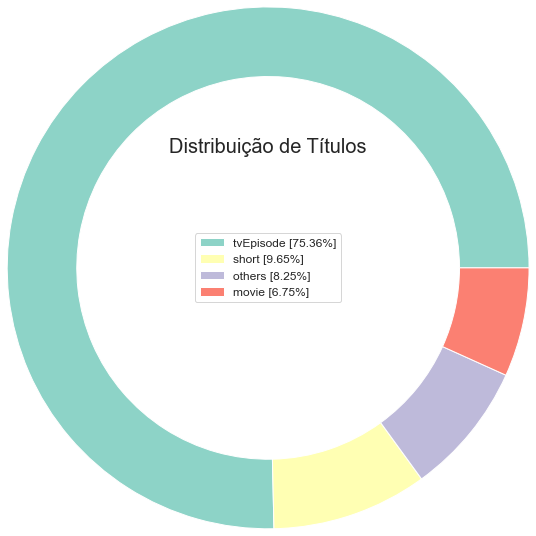

In [21]:
# Criando o gráfico:

# Ajuste dos labels
labels = [str(result_type_titles['type'][i])+' '+'['+str(round(result_type_titles['percentual'][i],2)) +'%'+']' for i in result_type_titles.index]

# Mapa de cores
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(result_type_titles['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

E com isso respondemos de forma clara que 75.36% dos registros no IMDB, até a presente data, são do tipo Episódio de TV.

#### 2- Qual o Gênero que possui mais títulos?

Para responder a essa pergunta, vamos calcular o número de filmes por gênero e entregar o resultado em formato percentual, assim como na pergunta anterior.

In [22]:
# Cria a consulta SQL
query_genres_titles = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [23]:
# Extrai o resultado e visualiza
result_genres_titles = pd.read_sql_query(query_genres_titles, conn)
display(result_genres_titles)

,genres,COUNT(*)
0,Action,14168
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",6
4,"Action,Adult,Crime",9
...,...,...
1460,"Thriller,Western",43
1461,War,1315
1462,"War,Western",14
1463,Western,5143


Como no banco de dados existem títulos que possuem mais de um gênero, acaba gerando essa grande quantidade de registros, e o \N indica que possuem 426970 títulos sem essa especificação, então, precisamos agrupar e tratar os dados por gênero único para conseguir definir os que aparecem mais. para isso:

In [24]:
# converter a string para minúsculo
result_genres_titles['genres'] = result_genres_titles['genres'].str.lower().values

In [25]:
# Dropar células com valores Null's (ausentes):
temp = result_genres_titles['genres'].dropna()

No próximo passo usarei o Countvectorizer, que é uma ferramenta de MachineLearning do pacote feature_extraction.text do sklearn, para converter a coluna de gêneros em um vetor one-hot encoded para contar o número de filmes em cada gênero, criando uma matriz esparsa que permitirá a contagem de cada gênero aplicando uma vetorização desse vetor one-hot encoded.

In [26]:
# Vamos criar um vetor usando expressão regular para filtrar as strings

# https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [27]:
# Conferindo o tipo
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [28]:
# Aplicando a vetorização ao dataset sem valores NA
bag_genres = vetor.transform(temp)
type(bag_genres)

scipy.sparse.csr.csr_matrix

In [29]:
# Retornando com os valores únicos
genres_uni = vetor.get_feature_names()

# Cria o dataframe de gêneros
genres = pd.DataFrame(bag_genres.todense(), columns = genres_uni, index = temp.index)

# Vizualizando o resultado
genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1465 entries, 0 to 1464
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1465 non-null   int64
 1   adult        1465 non-null   int64
 2   adventure    1465 non-null   int64
 3   animation    1465 non-null   int64
 4   biography    1465 non-null   int64
 5   comedy       1465 non-null   int64
 6   crime        1465 non-null   int64
 7   documentary  1465 non-null   int64
 8   drama        1465 non-null   int64
 9   family       1465 non-null   int64
 10  fantasy      1465 non-null   int64
 11  film-noir    1465 non-null   int64
 12  game-show    1465 non-null   int64
 13  history      1465 non-null   int64
 14  horror       1465 non-null   int64
 15  music        1465 non-null   int64
 16  musical      1465 non-null   int64
 17  mystery      1465 non-null   int64
 18  n            1465 non-null   int64
 19  news         1465 non-null   int64
 20  reality-

Criamos uma tabela "n" que não deveria existir para o nosso modelo, iremos realizar a exclusão desse dado pois não tem utilidade para nós.

In [30]:
# Dropando 'n' da tabela
genres = genres.drop(columns= 'n', axis = 0)

In [31]:
# Gera uma contagem de todos os generos
genres_serie = pd.Series(genres.sum().sort_values(ascending= False))
genres_serie

drama          263
comedy         249
documentary    233
adventure      217
action         211
romance        195
crime          191
mystery        182
thriller       180
horror         180
fantasy        177
history        168
sci-fi         165
family         164
animation      158
music          158
biography      156
musical        151
war            135
western        128
sport          121
adult           90
reality-tv      50
news            48
film-noir       37
short           23
talk-show       19
game-show       11
dtype: int64

In [32]:
# Transformando em porcentagem
genres_percent = (genres_serie /  len(genres)) * 100

In [33]:
genres_percent.head(10)

drama          17.952218
comedy         16.996587
documentary    15.904437
adventure      14.812287
action         14.402730
romance        13.310580
crime          13.037543
mystery        12.423208
thriller       12.286689
horror         12.286689
dtype: float64

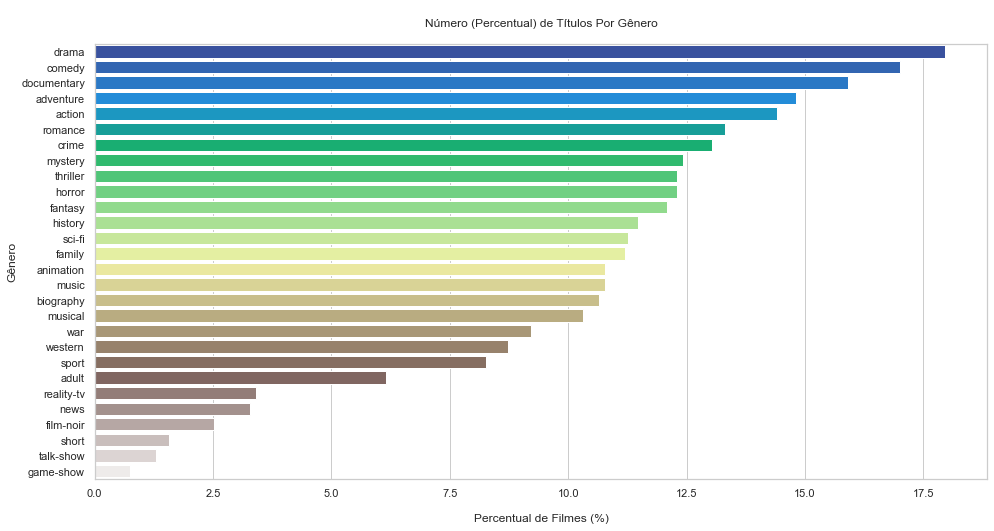

In [34]:
# Plotando isso em um gráfico
plt.figure(figsize = (16,8))
sns.barplot(x = genres_percent.values, y = genres_percent.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

Com base no gráfico gerado, dentre os que foram informados o gênero, o que possui mais títulos até a presente data é o **drama**, abrangendo hoje o aproximadamente 17.95% do total, seguido por **comédia** com 17% e **documentários** com 15.9% fechando nosso top 3 e o gênero com menor número de títulos é o **game-show** com menos de 1%.

#### 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?

A mediana é o valor central de uma distribuição, também chamada de ponto médio. Para responder a essa pergunta precisaremos utilizar as tabelas de títulos e de avaliação e descobrir qual a mediana de avaliação, vamos lá!

**Observação:** Eu só acho relevantes realizar essa contagem para os gêneros que possuem 1000 ou mais títulos, caso não possuam, irei descartar.

In [35]:
# Consulta SQL
query_rating_genres = '''
                        SELECT rating, genres FROM 
                        ratings JOIN titles ON ratings.title_id = titles.title_id
                        WHERE premiered <= 2022 AND type = 'movie'
                        '''

In [36]:
# Resultado da query
result_rating_genres = pd.read_sql_query(query_rating_genres, conn)
display(result_rating_genres)

,rating,genres
0,5.2,Romance
1,3.7,\N
2,6.0,"Action,Adventure,Biography"
3,4.0,Drama
4,4.1,Drama
...,...,...
281326,5.8,Thriller
281327,6.4,"Drama,History"
281328,3.8,"Adventure,History,War"
281329,8.3,Drama


In [37]:
# Vou criar uma função para retornar os gêneros:

def return_genres(df):
    df['genres'] = df['genres'].str.lower().values # retorna minusculo
    temp = df['genres'].dropna() # retira os itens NA
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp) # cria o vetor
    genres_uni = vetor.get_feature_names() # transforma em matriz esparsa
    genres_uni = [genre for genre in genres_uni if len(genre) > 1] # realiza a contagem
    return genres_uni #resultado da contagem

In [38]:
# Retorna os generos da query
genres_uni = return_genres(result_rating_genres)
genres_uni

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [39]:
# Cria listas vazias:
genre_counts = []
genre_ratings = []

# Loop
for item in genres_uni:
    
    # Retorna a contagem de filmes por gênero
    query = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    result = pd.read_sql_query(query, conn)
    genre_counts.append(result.values[0][0])
    
    # Retorna a avaliação dos filmes por gênero
    query =  'SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    result =  pd.read_sql_query(query, conn)
    genre_ratings.append(np.median(result['rating'])) #calcula a mediana
    

In [40]:
# Prepara o dataframe final
df_genre_ratings = pd.DataFrame()
df_genre_ratings['genres'] = genres_uni
df_genre_ratings['count'] = genre_counts
df_genre_ratings['rating'] = genre_ratings

In [41]:
# Visualizando o head
df_genre_ratings = df_genre_ratings.sort_values(by = 'count',ascending= False)
df_genre_ratings

,genres,count,rating
8,drama,124629,6.30
5,comedy,69457,6.00
7,documentary,42314,7.30
20,romance,31319,6.20
0,action,29167,5.80
6,crime,24079,6.10
25,thriller,23174,5.60
14,horror,20048,5.00
2,adventure,17655,6.00
15,music,12774,6.50


In [42]:
# Dropando os gêneros com menos de 50 títulos
df_genre_ratings = df_genre_ratings.drop(index = [11, 12, 18, 19, 22, 24])
df_genre_ratings

,genres,count,rating
8,drama,124629,6.3
5,comedy,69457,6.0
7,documentary,42314,7.3
20,romance,31319,6.2
0,action,29167,5.8
6,crime,24079,6.1
25,thriller,23174,5.6
14,horror,20048,5.0
2,adventure,17655,6.0
15,music,12774,6.5


In [43]:
# Ordena o resultado pela avaliação
df_genre_ratings = df_genre_ratings.sort_values(by = 'rating', ascending = False)
df_genre_ratings

,genres,count,rating
7,documentary,42314,7.3
4,biography,8588,7.0
13,history,7785,6.9
23,sport,3408,6.7
3,animation,4833,6.6
15,music,12774,6.5
26,war,5977,6.5
9,family,10847,6.3
8,drama,124629,6.3
16,musical,6256,6.2


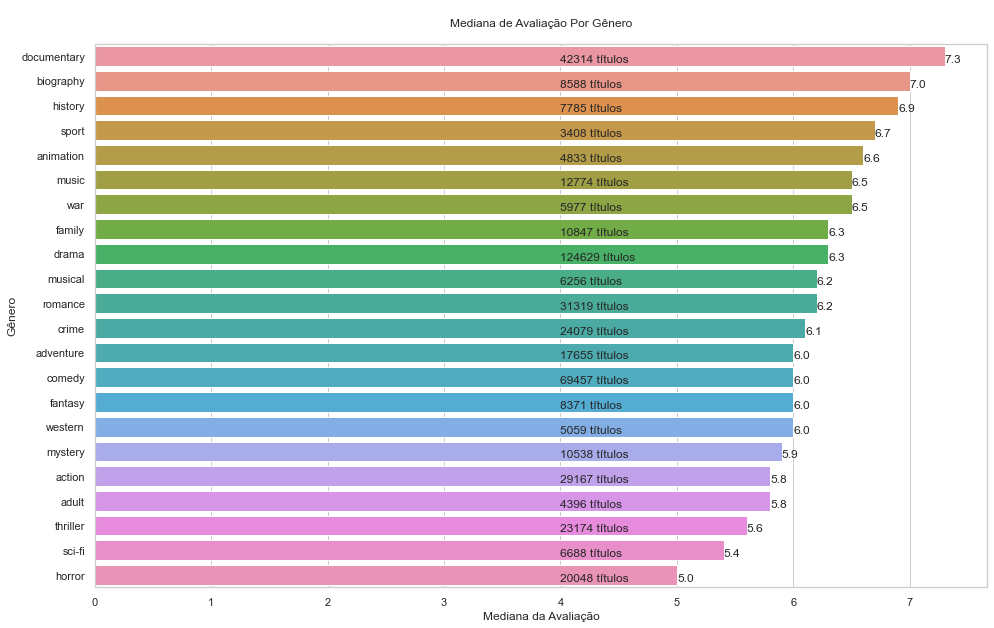

In [44]:
# Plota o gráfico

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genre_ratings.genres, x = df_genre_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genre_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genre_ratings['count'][df_genre_ratings.index[i]]) + " títulos")
    
    plt.text(df_genre_ratings.rating[df_genre_ratings.index[i]],
             i + 0.25,
             round(df_genre_ratings["rating"][df_genre_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

Com base no gráfico, podemos afirmar que se levarmos em consideração o fato da mediana ser a distribuição central das notas de avaliação dos títulos, ou seja, o ponto médio, e que considerarmos as notas de avaliação de 0.0 a 10.0, sendo 0.0 considerado como péssimo e 10.0 como ótimo, os gêneros com mais avaliações de muito boas para excelente (acima de 7.0) são os **documentários** e os de **biografia**.

#### 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

Para resolver essa query utilizaremos uma lógica bem parecida com a anterior. Para a amostra vou classificar apenas os filmes estreados a partir da década de 1920, ou seja, fazer um estudo do último século, de 1922 à 2022.

In [45]:
# Consulta SQL
query_rating_premiered = '''
                            SELECT rating AS Rating, premiered FROM ratings
                            JOIN titles ON ratings.title_id = titles.title_id
                            WHERE premiered <= 2022 AND premiered >= 1922 AND type = 'movie'
                            ORDER BY premiered
                         '''

In [46]:
result_rating_premiered = pd.read_sql_query(query_rating_premiered, conn)
result_rating_premiered.head

<bound method NDFrame.head of         Rating  premiered
0          6.4       1922
1          6.8       1922
2          6.7       1922
3          4.7       1922
4          5.2       1922
...        ...        ...
278957     7.8       2022
278958     6.8       2022
278959     5.3       2022
278960     4.1       2022
278961     4.1       2022

[278962 rows x 2 columns]>

In [47]:
result_rating_premiered.head()

,Rating,premiered
0,6.4,1922
1,6.8,1922
2,6.7,1922
3,4.7,1922
4,5.2,1922


Conseguimos fazer a consulta de forma correta pois foi retornado os títulos e avaliações dos filmes de 1922 à 2022, agora precisamos agrupar pelo ano de estréia.

In [48]:
# Agrupando as avaliações pelo ano e calculando a mediana:

ratings = []
for year in set(result_rating_premiered['premiered']):
    ratings.append(np.median(result_rating_premiered[result_rating_premiered['premiered'] == year]['Rating']))
    
ratings[1:10]

[6.2, 6.3, 6.3, 6.4, 6.4, 6.6, 6.4, 6.1, 5.9]

In [49]:
# Criando a lista de anos

year = list(set(result_rating_premiered['premiered']))
print(year[:5], year[-5:])

[1922, 1923, 1924, 1925, 1926] [2018, 2019, 2020, 2021, 2022]


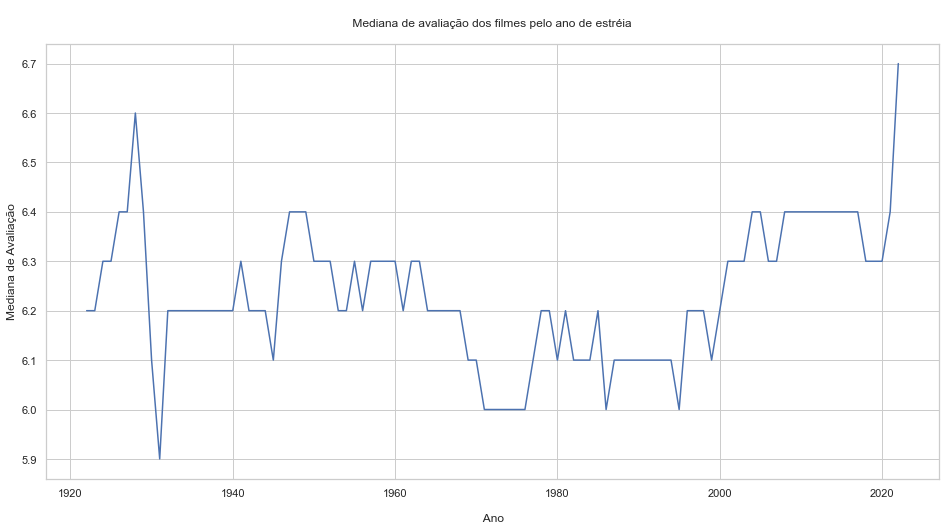

In [50]:
#Plot
plt.figure(figsize = (16, 8))
plt.plot(year, ratings)
plt.xlabel('\n Ano')
plt.ylabel('Mediana de Avaliação')
plt.title('\n Mediana de avaliação dos filmes pelo ano de estréia \n')
plt.show()

Com o gráfico vemos uma melhora significativa na mediana das avaliações a partir do ano 2000. Podemos atribuir a esse fato que a quantidade de pessoas que assistem à filmes mais recentes, ou seja a quantidade de amostras, cresce a cada ano e consequentemente aumenta também a quantidade de notas de avaliação mais altas, subindo o valor da mediana.

### 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

Para responder a essa pergunta, vamos precisar apenas da tabela titles. Vou listar o top 5 em um gráfico.

In [51]:
# Consulta SQL
query_genre_year = '''SELECT genres FROM titles'''

In [52]:
# Resultado dos dados
result_genre_year = pd.read_sql_query(query_genre_year, conn)
display(result_genre_year)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
9183644,"Action,Drama,Family"
9183645,"Action,Drama,Family"
9183646,"Action,Drama,Family"
9183647,Short


In [53]:
# Utilizando a função criada para retornar os generos únicos

genre_uni = return_genres(result_genre_year)
display(genre_uni)

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [54]:
# Contagem

genre_count = []
for item in genre_uni:
    consult = 'SELECT COUNT(*) AS COUNT FROM titles WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type =\'movie\' AND premiered <=2022 and premiered >=1922'
    result = pd.read_sql_query(consult, conn)
    genre_count.append(result['COUNT'].values[0])

In [55]:
# Preparando o dataFrame
df_genre_count = pd.DataFrame()
df_genre_count['genre'] = genre_uni
df_genre_count['Count'] = genre_count
display(df_genre_count)

,genre,Count
0,action,41647
1,adult,8645
2,adventure,22259
3,animation,6994
4,biography,13884
5,comedy,90857
6,crime,30344
7,documentary,107552
8,drama,187898
9,family,15166


In [56]:
# Calculando o top 5:

df_genre_count = df_genre_count[df_genre_count['genre'] != 'n']
df_genre_count = df_genre_count.sort_values(by = 'Count', ascending = False)
df_genre_count = df_genre_count.head()['genre'].values # retorna os 5 maiores (primeiros) registros

In [57]:
display(df_genre_count)

array(['drama', 'documentary', 'comedy', 'action', 'romance'],
      dtype=object)

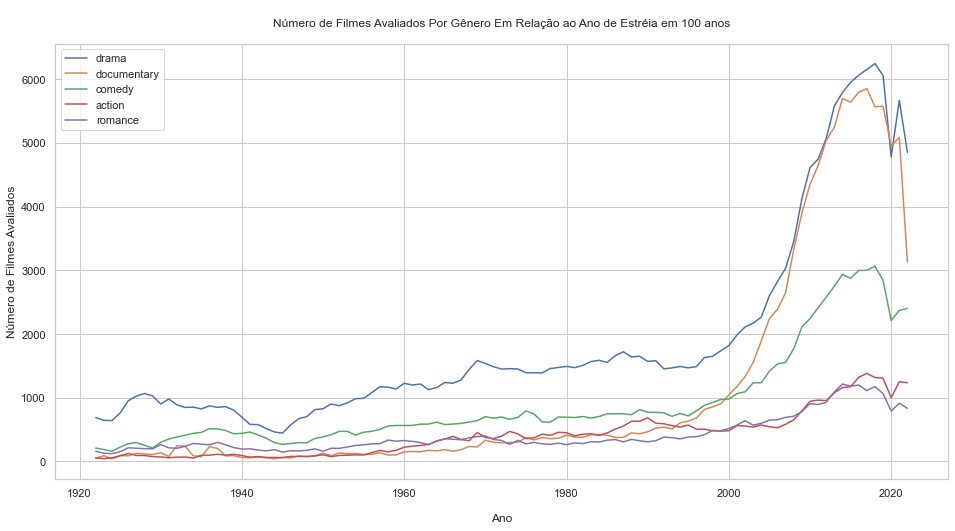

In [58]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in df_genre_count:
    query = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 AND Year >= 1922 GROUP BY Year'
    result = pd.read_sql_query(query, conn)
    plt.plot(result['Year'], result['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia em 100 anos\n')
plt.legend(labels = df_genre_count)
plt.show()

Podemos ver no gráfico que houve um aumento significativo nas avaliações a partir do ano 2000, isso se dá pela fenômeno de globalização, com mais pessoas tendo acesso à internet, a quantidade de avaliações aumenta.

### 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

Em busca do filme com maior duração da história, além dele, vou trazer o top 5 maiores filmes, vamos lá!

In [59]:
# Consulta SQL

query_runtime = ''' SELECT runtime_minutes Runtime 
                    FROM titles
                    WHERE type = 'movie' AND Runtime <> 'NaN'
                '''

In [60]:
# Resultado da consulta
result_runtime = pd.read_sql_query(query_runtime, conn)

In [61]:
display(result_runtime)

,Runtime
0,45
1,100
2,70
3,90
4,120
...,...
390952,123
390953,57
390954,100
390955,116


In [62]:
# Loop para cálculos dos percentís
for i in range(101):
    val = i
    perc = round(np.percentile(result_runtime['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 51.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 57.0
11 percentil da duração (runtime) é: 58.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 62.0
17 percentil da duração (runtime) é: 64.0
18 percentil da duração (runtime) é: 65.0
19 percentil da duração (runtime) é: 67.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 71.0
24 

In [63]:
# Refazendo a consulta e retornando o filme com maior duração
query_film = '''
             SELECT runtime_minutes Runtime, primary_title Title
             FROM titles 
             WHERE type = 'movie' AND Runtime != 'NaN'
             ORDER BY Runtime DESC
             LIMIT 5
             '''

In [64]:
result_film = pd.read_sql_query(query_film, conn)

In [65]:
display(result_film)

,Runtime,Title
0,51420,Logistics
1,43200,Ambiancé
2,28643,Carnets Filmés (Liste Complète)
3,14400,Modern Times Forever
4,10062,Qw


Com isso temos nosso top 5 filmes com maiores durações, sendo o 'Logistics' o filme mais longo da história (até este momento), com 857 horas (51420 minutos). Dirigido por Daniel Andersson e Erika Magnusson, o filme acompanha todo o ciclo de vida de um pedômetro (dispositivo de rastreamento de passos) em ordem cronológica reversa. Curioso não? 😂

### 7- Qual a Relação Entre Duração e Gênero?

Vamos agora descobrir qual a relação entre essas duas variáveis, presentes  também na tabela títulos.

In [66]:
# Consulta SQL
query_runtime_genre = '''
                      SELECT AVG(runtime_minutes) Runtime, genres 
                      FROM titles 
                      WHERE type = 'movie'
                      AND runtime_minutes != 'NaN'
                      GROUP BY genres
                      ''' 

# Resultado da consulta
result_runtime_genre = pd.read_sql_query(query_runtime_genre, conn)
display(result_runtime_genre)

,Runtime,genres
0,99.331815,Action
1,77.000000,"Action,Adult"
2,85.000000,"Action,Adult,Adventure"
3,76.400000,"Action,Adult,Comedy"
4,85.375000,"Action,Adult,Crime"
...,...,...
1377,95.266667,"Thriller,Western"
1378,93.754870,War
1379,90.000000,"War,Western"
1380,69.999503,Western


In [67]:
# Tornando os gêneros únicos novamente
genre_uni = return_genres(result_runtime_genre)
display(genre_uni)

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [68]:
# Calculando a duração por gênero
genre_runtime = []
for item in genre_uni:
    query = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    result = pd.read_sql_query(query, conn)
    genre_runtime.append(np.median(result['Runtime']))

In [69]:
# Prepara o dataframe
df_genre_runtime = pd.DataFrame()
df_genre_runtime['genre'] = genre_uni
df_genre_runtime['runtime'] = genre_runtime
df_genre_runtime

,genre,runtime
0,action,94.0
1,adult,78.0
2,adventure,90.0
3,animation,81.0
4,biography,87.0
5,comedy,91.0
6,crime,92.0
7,documentary,74.0
8,drama,93.0
9,family,89.0


In [70]:
# Ordena os dados
df_genre_runtime = df_genre_runtime.sort_values(by = 'runtime', ascending = False)

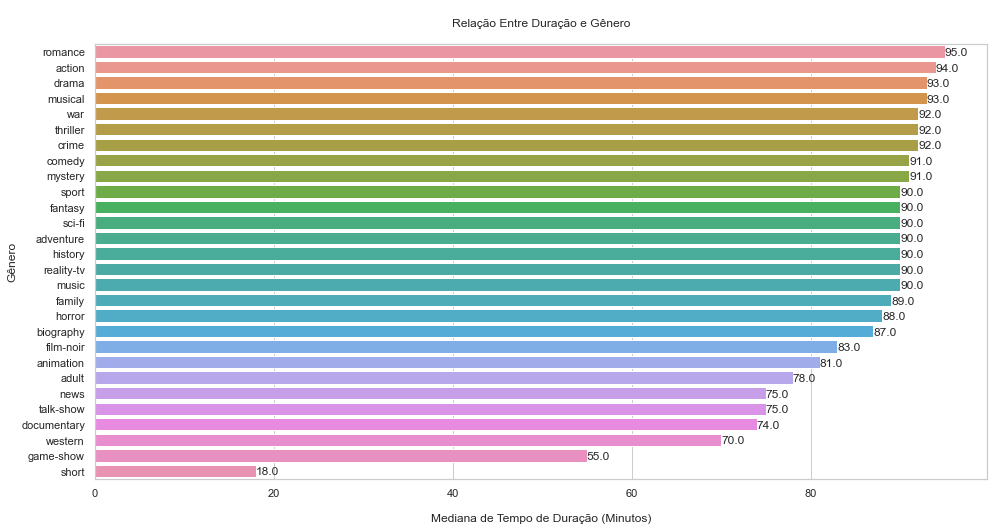

In [71]:
# Plot

# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genre_runtime.genre, x = df_genre_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genre_runtime.index)):
    plt.text(df_genre_runtime.runtime[df_genre_runtime.index[i]],
             i + 0.25,
             round(df_genre_runtime["runtime"][df_genre_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

Com isso, respondemos a pergunta 7, pelo gráfico podemos identificar que o gênero de filmes que tem a maior mediana é de romance, seguido de ação e drama.

### 8 - Qual o número de filmes produzidos por país?

Vamos agora analisar e descobrir qual o top 10 países produtores de filmes, segundo o IMDB.

In [72]:
# Consulta SQL
query_region = '''
               SELECT region, COUNT(*) Number_of_movies FROM
               akas JOIN titles ON
               akas.title_id = titles.title_id
               WHERE region <> 'None'
               AND type = 'movie'
               GROUP BY region
               '''

# Resultado da consulta
result_region = pd.read_sql_query(query_region, conn)
display(result_region)

,region,Number_of_movies
0,AD,21
1,AE,7301
2,AF,110
3,AG,12
4,AL,1296
...,...,...
229,YUCS,153
230,ZA,7724
231,ZM,17
232,ZRCD,2


Para realizar a conversão do código das regiões para os nomes dos países vamos usar o pycountry e passar um for para percorrer a lista que criamos.

In [73]:
# Número de linhas
result_region.shape[0]

234

In [74]:
# Convertendo o COD para o nome dos países

name_country = []
count = []

for i in range(result_region.shape[0]):
    try:
        coun = result_region['region'].values[i]
        name_country.append(pycountry.countries.get(alpha_2 = coun).name)
        count.append(result_region['Number_of_movies'].values[i])
    except:
        continue

In [75]:
# Prepara o DataFrame
df_movie_country = pd.DataFrame()
df_movie_country['Country'] = name_country
df_movie_country['Movie_Count'] = count

# Ordenando o resultado
df_movie_country = df_movie_country.sort_values(by = 'Movie_Count', ascending = False)

# Visualiza o top 10
df_movie_country.head(10)

,Country,Movie_Count
199,United States,316517
65,United Kingdom,161087
96,Japan,93159
63,France,86020
89,India,85660
32,Canada,81167
47,Germany,72474
58,Spain,67072
93,Italy,66580
26,Brazil,66453


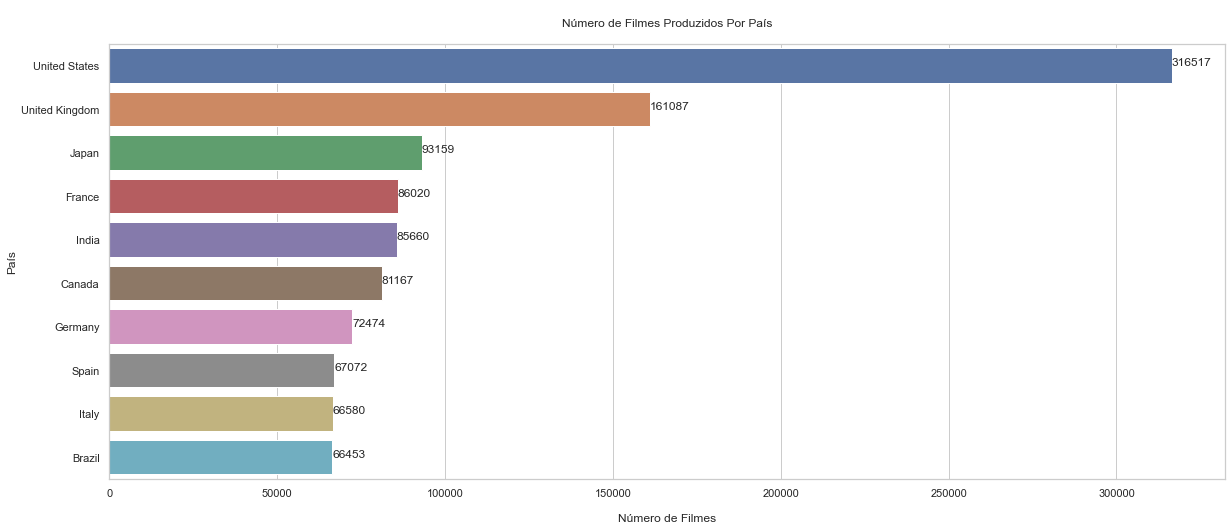

In [76]:
# Plotando no gráfico

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_movie_country[:10].Country, x = df_movie_country[:10].Movie_Count, orient = "h")

# Loop
for i in range(0,10):
    plt.text(df_movie_country.Movie_Count[df_movie_country.index[i]],
             i,
             round(df_movie_country["Movie_Count"][df_movie_country.index[i]]))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

Chegamos a conclusão que os Estados Unidos lideram o ranking disparados na frente, seguido por Reino Unido e Japão. A grande surpresa foi ver que o Brasil está no top 10 (exatamente na 10ª colocação) e bem próximo de Itália e Espanha. Vamos a penúltima pergunta!

### 9 - Quais são os top 10 melhores filmes?

Essa é a pergunta que eu estou mais curioso em saber. Vamos descobrir quais são os 10 melhores filmes da históra e para ser justo, vamos apenas considerar os filmes que possuírem mais de 25.000 avaliações, dessa forma, o resultado será fidedigno às amostras avaliadas. Vamos começar!

In [77]:
# Consulta SQL
query_bestmovie =  '''
                   SELECT primary_title AS Movie_Name, premiered, genres, rating
                   FROM 
                   titles JOIN ratings
                   ON  titles.title_id = ratings.title_id
                   WHERE titles.type = 'movie' AND ratings.votes >= 25000
                   ORDER BY rating DESC
                   LIMIT 10          
                   ''' 
# Resultado da consulta
result_bestmovie = pd.read_sql_query(query_bestmovie, conn)
display(result_bestmovie)

,Movie_Name,premiered,genres,rating
0,The Shawshank Redemption,1994,Drama,9.3
1,The Godfather,1972,"Crime,Drama",9.2
2,The Chaos Class,1975,"Comedy,Drama",9.2
3,CM101MMXI Fundamentals,2013,"Comedy,Documentary",9.1
4,12 Angry Men,1957,"Crime,Drama",9.0
5,The Godfather Part II,1974,"Crime,Drama",9.0
6,Schindler's List,1993,"Biography,Drama,History",9.0
7,The Lord of the Rings: The Return of the King,2003,"Action,Adventure,Drama",9.0
8,The Dark Knight,2008,"Action,Crime,Drama",9.0
9,Mirror Game,2016,"Crime,Mystery,Thriller",9.0


Com isso temos o nosso top 10 com The Shawshank Redemption (Um Sonho de Liberdade), filme de 1994, em primeiro lugar com avaliação de 9.3/10, seguido por The Godfather (O Poderoso Chefão), de 1972, e The Chaos Class (filme turco de 1975 sem tradução para Pt.BR), empatados em segundo com 9.2/10 e CM101MMXI Fundamentals (filme também turco de 2013) em terceiro com 9.1/10.

## 10- Quais São os Top 10 Piores Filmes?

E vamos a 10ª e última pergunta, mas não menos importante. Para responder a essa pergunta também usaremos como critério de consulta os filmes que possuírem mais de 25.000 avaliações. Vamos ao código!

In [78]:
# Consulta SQL
query_worstmovie = '''
                    SELECT primary_title AS Movie_Name, premiered, genres, rating
                    FROM titles JOIN ratings ON
                    titles.title_id = ratings.title_id
                    WHERE titles.type = 'movie' AND votes >= 25000
                    ORDER BY rating ASC
                    LIMIT 10
                    '''

# Retorno da consulta
result_worstmovie = pd.read_sql_query(query_worstmovie, conn)
display(result_worstmovie)

,Movie_Name,premiered,genres,rating
0,Reis,2017,"Biography,Drama",1.0
1,Cumali Ceber,2017,Comedy,1.0
2,Sadak 2,2020,"Action,Drama",1.1
3,Smolensk,2016,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,2004,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,2021,"Crime,Drama,History",1.5
6,Manos: The Hands of Fate,1966,Horror,1.6
7,Justin Bieber: Never Say Never,2011,"Documentary,Music",1.6
8,From Justin to Kelly,2003,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,2008,"Comedy,Romance",1.9


E o título de pior filme tem pódio duplo entre Reis, filme de 2017 dirigido por Niles Atallah, e Cumali Ceber, também de 2017 dirigiro por  Gökhan Gök e Kamil Çetin.

E com isso finalizamos nosso projeto de análise de dados, parte dos códigos foram desenvolvidos pela Data Science Academy, no módulo 6 do curso de Python fundamentos para análise de dados e implementados por mim, se você chegou até aqui, meus sinceros agradecimentos e até a próxima!

## Fim!